In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

2024-11-19 13:49:37.656019: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-19 13:49:38.042930: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731998978.210130   16557 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731998978.249065   16557 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-19 13:49:38.551346: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
NEG_PATH = '/home/leloc/Documents/USTH-B3/Group_project/Model/negative'
POS_PATH = '/home/leloc/Documents/USTH-B3/Group_project/Model/positive'
ANC_PATH = '/home/leloc/Documents/USTH-B3/Group_project/Model/anchor'

In [4]:
# Negative dataset : https://www.kaggle.com/datasets/jessicali9530/lfw-dataset
for directory in os.listdir('/home/leloc/Documents/USTH-B3/Group_project/Model/lfw-deepfunneled'):
    for file in os.listdir(os.path.join('/home/leloc/Documents/USTH-B3/Group_project/Model/lfw-deepfunneled', directory)):
        EX_PATH = os.path.join('/home/leloc/Documents/USTH-B3/Group_project/Model/lfw-deepfunneled', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)


In [5]:
# Random but unique name for img
import uuid

In [6]:
# Use camera
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret,frame = cap.read()
    #250x250 pixel
    frame = frame[ 200:200+250, 170:170+250, :]
    
    #Collect anchor
    if cv2.waitKey(1) == ord('a'):
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)

    #Collect positive
    if cv2.waitKey(1) == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
        

    #Show image
    cv2.imshow('IMAGE', frame)
    
    if cv2.waitKey(1) == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [6]:
anchor = tf.data.Dataset.list_files(ANC_PATH +'/*.jpg').take(500)
positive = tf.data.Dataset.list_files(POS_PATH +'/*.jpg').take(500)
negative = tf.data.Dataset.list_files(NEG_PATH +'/*.jpg').take(500)

I0000 00:00:1731999012.423196   16557 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2266 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [7]:
img_test = anchor.as_numpy_iterator()
print(img_test.next())

b'/home/leloc/Documents/USTH-B3/Group_project/Model/anchor/43b6dc03-7413-11ef-b9a4-e81f155e7428.jpg'


In [8]:
def preprocess(file_path):
    read_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(read_img)

    img = tf.image.resize(img, (105,105))
    img = img/255.0
    return img

In [9]:
img = preprocess('/home/leloc/Documents/USTH-B3/Group_project/Model/anchor/43b6dc03-7413-11ef-b9a4-e81f155e7428.jpg')

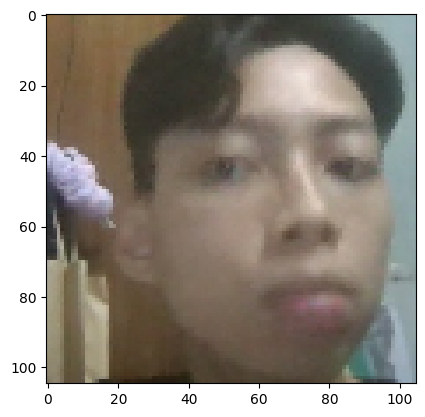

In [10]:
plt.imshow(img)

In [11]:
positives = tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [12]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [13]:
try_img = data.as_numpy_iterator()
try_img = try_img.next()
try_img

(b'/home/leloc/Documents/USTH-B3/Group_project/Model/anchor/4d2b4213-7413-11ef-b424-e81f155e7428.jpg',
 b'/home/leloc/Documents/USTH-B3/Group_project/Model/positive/b3141c5a-7413-11ef-b74a-e81f155e7428.jpg',
 np.float32(1.0))

In [14]:
def double_check(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)


In [16]:
res = double_check(*try_img)
res

(<tf.Tensor: shape=(105, 105, 3), dtype=float32, numpy=
 array([[[0.52866924, 0.43063003, 0.31298295],
         [0.5261571 , 0.42755768, 0.30626917],
         [0.5334868 , 0.42760438, 0.30995733],
         ...,
         [0.6346183 , 0.7076564 , 0.74564713],
         [0.63145924, 0.7060757 , 0.7337868 ],
         [0.61325866, 0.69169   , 0.719141  ]],
 
        [[0.5172802 , 0.41924104, 0.301594  ],
         [0.5002801 , 0.40116045, 0.28039217],
         [0.52769774, 0.42181537, 0.3041683 ],
         ...,
         [0.621602  , 0.7117981 , 0.7353275 ],
         [0.61988795, 0.7137255 , 0.72997195],
         [0.61624646, 0.7095238 , 0.7254902 ]],
 
        [[0.51473033, 0.41314304, 0.29727003],
         [0.5109244 , 0.40504202, 0.29103643],
         [0.5319883 , 0.426106  , 0.30845892],
         ...,
         [0.6294296 , 0.70980394, 0.7362834 ],
         [0.62907165, 0.70831   , 0.7316193 ],
         [0.62707746, 0.7058824 , 0.72903824]],
 
        ...,
 
        [[0.56509054, 0.5454827 

In [17]:
#build pipline
data = data.map(double_check)
data = data.cache()
data = data.shuffle(buffer_size=2000)

In [18]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [19]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [37]:
test_data = data.skip(round(len(data)*.7))
test_data = data.take(round(len(data)*.3))
test_data = data.batch(16)
test_data = data.prefetch(8)


## Model

In [62]:
def make_embedding(): 
    inp = Input(shape=(105,105,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=inp, outputs=d1, name='embedding')

In [63]:
embed = make_embedding()
embed.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 105, 105, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 96, 96, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 42, 42, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 18, 18, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
# Siamese L1 Distance class
class L1Dist(tf.keras.layers.Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, inputs):
        input_embedding,validation_embedding = inputs
        return tf.math.abs(input_embedding - validation_embedding)

In [67]:
def make_siames_model():
    input_image = Input(name='input_img', shape=(105,105,3))
    validation_image = Input(name='validation_img', shape=(105,105,3))

    siamese_layer = L1Dist()
    siamese_layer.name = 'distance'
    distances = siamese_layer([embed(input_image), embed(validation_image)])

    classifier = Dense(1, activation ='sigmoid')(distances)

    return Model(inputs = [input_image, validation_image], outputs = classifier, name = 'Siamese_Network')


In [68]:
siamese_model = make_siames_model()

siamese_model.summary()

Model: "Siamese_Network"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distance (L1Dist)   │ (None, 4096)      │          0 │ embedding[2][0],  │
│                     │                   │            │ embedding[3][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │      4,097 │ distance[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

## Trainning


### Set up loss and optimize

In [69]:
binary_cross_loss = tf._losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)

In [70]:
checkpoint_dir = './home/leloc/Documents/USTH-B3/Group_project/Model/trainning_checkpoint'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt = opt, siamese_model =siamese_model)


In [71]:
test_batch = train_data.as_numpy_iterator()
batch_1 = test_batch.next()
X = batch_1[:2]
y = batch_1[2]
y

array([0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1.],
      dtype=float32)

In [72]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        # Tách batch thành đầu vào và nhãn
        X = batch[:2]
        y = batch[2]

        # Dự đoán đầu ra từ mô hình
        y_pred = siamese_model(X, training=True)

        # Tính toán mất mát
        loss = binary_cross_loss(y, y_pred)
        print(loss)

    # Tính gradient đối với các tham số có thể huấn luyện
    gradients = tape.gradient(loss, siamese_model.trainable_variables)

    # Áp dụng các gradient vào mô hình
    opt.apply_gradients(zip(gradients, siamese_model.trainable_variables))

    return loss

        

In [73]:
from tensorflow.keras.metrics import Precision, Recall

In [31]:
def train(data, EPOCH):
    for epoch in range (1, EPOCH + 1):
        print('\n Epoch {}/{}'.format(epoch, EPOCH))
        progbar = tf.keras.utils.Progbar(len(data))

        r = Recall()
        p = Precision()

        for idx, batch in enumerate(data):
            loss = train_step(batch)
            y_pred = siamese_model.predict(batch[:2])
            r.update_state(batch[2], y_pred)
            p.update_state(batch[2], y_pred)
            progbar.update(idx+1)
    print(loss.numpy(), r.result().numpy(), p.result().numpy())

    if epoch % 10 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)

In [32]:
EPOCH = 10

In [33]:
train(train_data, EPOCH)


 Epoch 1/10


/home/leloc/anaconda3/envs/facial_reg/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_img', 'validation_img']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)


I0000 00:00:1731999060.365194   26341 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1731999066.119037   26341 service.cc:148] XLA service 0x7c6f19695160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731999066.128101   26341 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-11-19 13:51:06.165017: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


I0000 00:00:1731999069.166443   26341 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/stepe
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1

2024-11-19 13:51:36.045106: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/stept

2024-11-19 13:51:57.869305: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/stepe
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━

2024-11-19 13:52:33.547382: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/stepe
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━

2024-11-19 13:53:44.763757: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/steptep
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/stepte
1/1 

In [91]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
print(test_input.shape)  # Phải là (1, 105, 105, 3)
print(test_val.shape)

(105, 105, 3)
(105, 105, 3)


In [92]:
import numpy as np
test_input = np.expand_dims(test_input, axis=0)  # Từ (105, 105, 3) -> (1, 105, 105, 3)
test_val = np.expand_dims(test_val, axis=0) 
print(test_input.shape)  # Phải là (1, 105, 105, 3)
print(test_val.shape)     # Từ (105, 105, 3) -> (1, 105, 105, 3)


(1, 105, 105, 3)
(1, 105, 105, 3)


In [93]:
y_hat = siamese_model.predict([test_input, test_val])



/home/leloc/anaconda3/envs/facial_reg/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_img', 'validation_img']. Received: the structure of inputs=('*', '*')
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [94]:
y_true

np.float32(1.0)

In [95]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

ValueError: as_list() is not defined on an unknown TensorShape.

In [137]:
siamese_model.save('/home/leloc/Documents/USTH-B3/Group_project/Model/siamesemodel.h5')